In [7]:
#!pip install pyvis

In [8]:
from pyvis.network import Network

In [9]:
from configparser import ConfigParser
from tqdm import tqdm
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import requests
import openai
import json
import os

In [10]:
# Get API key stored in local cfg file
# How to is available here : https://towardsdatascience.com/keeping-credentials-safe-in-jupyter-notebooks-fbd215a8e311

parser = ConfigParser()
_ = parser.read('ObsidianGPT.cfg')
openai.api_key = parser.get('my_api', 'auth_key')

In [11]:
def generate_text(prompt, GPTmodel):
    response = openai.ChatCompletion.create(model=GPTmodel,messages=[{"role": "user", "content": prompt}])
    return response.choices[0].message.content.strip()

# Connect to GPT4

In [13]:
company_name = "Mulliez Group"

In [21]:
# Get the list of models for different kinds of data from the GPT API
models_prompt = f"""
"Could you please provide a list
of all the subsidiaries in which {company_name} 
holds a majority stake as of the most recent data available?"
"""

In [22]:
%%time
# Get the list of models, for each data type and problem type
models_text = generate_text(models_prompt, GPTmodel="gpt-4") #or gpt-3.5-turbo for faster results vs lower query quality
models_text

CPU times: user 19.3 ms, sys: 5.43 ms, total: 24.8 ms
Wall time: 57.7 s


"As of the most recent data available, Mulliez Group holds a majority stake in the following subsidiaries:\n\n1. Auchan Retail - A global retail group operating in many countries.\n2. Adeo - A home improvement and gardening retail chain, which manages brands like Leroy Merlin, Bricoman, and Weldom.\n3. Decathlon - A sporting goods retailer with stores worldwide.\n4. Norauto - An automotive services and retail company.\n5. Kiabi - A fashion retail company with stores mostly in Europe.\n6. Saint Maclou - A home decoration retail chain specializing in flooring and wall coverings.\n7. Boulanger - A consumer electronics and appliances retail company.\n8. Pabe - A Belgium-based holding company that owns several businesses, including Jules, a men's fashion retail brand.\n9. PicwicToys - A toy retail company in France.\n10. Cultura - A French retail chain specializing in cultural and creative products, such as books, music, and stationery.\n11. Oney - A financial services company offering bank

In [9]:
today=datetime.datetime.now()

In [11]:
#save models dict to disk with current date
with open(f'raw_models_{today}.txt', 'w') as convert_file:
     convert_file.write(json.dumps(models_text))

In [23]:
response_=models_text
lines = response_.strip().split('\n')
lines

['As of the most recent data available, Mulliez Group holds a majority stake in the following subsidiaries:',
 '',
 '1. Auchan Retail - A global retail group operating in many countries.',
 '2. Adeo - A home improvement and gardening retail chain, which manages brands like Leroy Merlin, Bricoman, and Weldom.',
 '3. Decathlon - A sporting goods retailer with stores worldwide.',
 '4. Norauto - An automotive services and retail company.',
 '5. Kiabi - A fashion retail company with stores mostly in Europe.',
 '6. Saint Maclou - A home decoration retail chain specializing in flooring and wall coverings.',
 '7. Boulanger - A consumer electronics and appliances retail company.',
 "8. Pabe - A Belgium-based holding company that owns several businesses, including Jules, a men's fashion retail brand.",
 '9. PicwicToys - A toy retail company in France.',
 '10. Cultura - A French retail chain specializing in cultural and creative products, such as books, music, and stationery.',
 '11. Oney - A fin

# Psychology Exploration 

## v1 - Static Graph

In [32]:
G=nx.Graph()
category = ''
for line in lines:
    line = line.strip()
    if not line:  # if it's an empty line, skip
        continue
    if line.endswith(':'):  # if it's a category line
        category = line[:-1]
        continue
    if '-' in item:  # if there's a '-' in the line, it's a figure or theory
        item, associated = item.split('-', 1)
        print(item)
        item = item.strip()
        associated = associated.strip()
        G.add_edge(item, associated)
    else:  # if it's a subfield, just add the node
        G.add_node(item, type=category.lower())

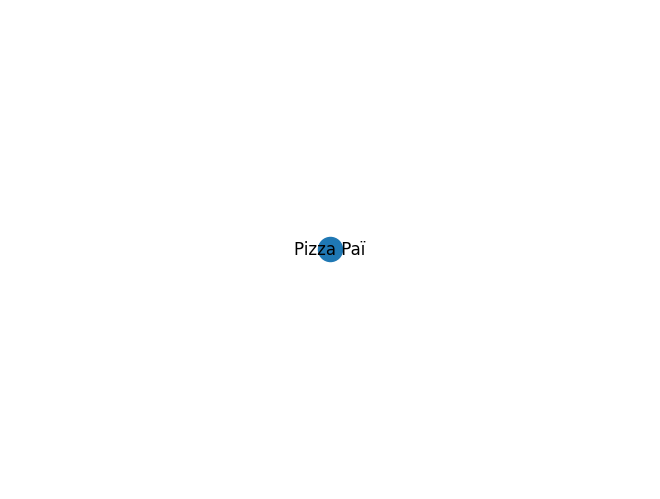

In [31]:
# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

## v2 - Interactive Graph

In [55]:
### Local Reset to raw data
response_=models_text
lines = response_.strip().split('\n')
###

category = ''
for line in lines:
    line = line.strip()
    if not line:  # if it's an empty line, skip
        continue
    if line.endswith(':'):  # if it's a category line
        category = line[:-1]
        print(category)
        continue
    item = line[line.index('. ')+2:]  # get rid of "a. ", "b. ", etc.
    print(item)
    if '-' in item:  # if there's a '-' in the line, it's a figure or theory
        item, associated = item.split('-', 1)
        item = item.strip()
        associated = associated.strip()
        G.add_edge(item, associated)
    elif 'related to' in item:  # if there's a 'related to' in the line, it's a concept
        item, related = item.split('related to', 1)
        item = item.strip()
        related = related.strip().strip('()')  # remove parentheses
        G.add_edge(item, related)
    else:  # if it's a subfield, just add the node
        G.add_node(item, type=category.lower())

# Convert to a pyvis network
net = Network(notebook=True)
net.from_nx(G)

# Show the interactive graph
net.show("psychology_graph.html")

1. Subfields
Cognitive Psychology
Developmental Psychology
Social Psychology
Clinical Psychology
Biological Psychology
Industrial-Organizational Psychology
Health Psychology
Forensic Psychology
Personality Psychology
2. Key Figures
Sigmund Freud - Psychoanalysis
Carl Jung - Analytical Psychology
B.F. Skinner - Behaviorism
Jean Piaget - Developmental Psychology
Albert Bandura - Social Learning Theory
Lev Vygotsky - Cognitive Development
Carl Rogers - Humanistic Psychology
Abraham Maslow - Humanistic Psychology, Hierarchy of Needs
Stanley Milgram - Social Psychology
Philip Zimbardo - Social Psychology
3. Theories
Psychoanalysis - Sigmund Freud
Behaviorism - B.F. Skinner
Cognitive Development Theory - Jean Piaget
Social Learning Theory - Albert Bandura
Zone of Proximal Development - Lev Vygotsky
Humanistic Psychology - Carl Rogers, Abraham Maslow
Hierarchy of Needs - Abraham Maslow
Theory of Cognitive Dissonance - Leon Festinger
Attachment Theory - John Bowlby and Mary Ainsworth
4. Concep

## v3 - Updates to the GPT Prompt

In [57]:
prompt_v3 = (
    "Could you please provide an organized and detailed breakdown of the field of psychology? "
    "This should include the following information:\n\n"
    "1. Major subfields of psychology, listed individually.\n"
    "2. Key figures in psychology, listed individually along with their main contributions or theories.\n"
    "3. Main theories in psychology, listed individually along with their associated figures or contributors.\n"
    "4. Major concepts in psychology, listed individually along with their associated theories or contributors.\n\n"
    "Please provide the information in the following format:\n\n"
    "1. Subfields:\n"
    "   a. [Subfield 1]\n"
    "   b. [Subfield 2]\n"
    "   ...\n"
    "2. Key figures:\n"
    "   a. [Figure 1] - [Contribution or theory]\n"
    "   b. [Figure 2] - [Contribution or theory]\n"
    "   ...\n"
    "3. Theories:\n"
    "   a. [Theory 1] - [Associated figure or contributor]\n"
    "   b. [Theory 2] - [Associated figure or contributor]\n"
    "   ...\n"
    "4. Concepts:\n"
    "   a. [Concept 1] - related to [Associated theory or figure]\n"
    "   b. [Concept 2] - related to [Associated theory or figure]\n"
    "   ..."
)


In [59]:
%%time
# Get the list of models, for each data type and problem type
response_v3 = generate_text(prompt_v3, GPTmodel="gpt-4") #or gpt-3.5-turbo for faster results vs lower query quality
response_v3


CPU times: user 41.2 ms, sys: 19.2 ms, total: 60.5 ms
Wall time: 1min 43s


'1. Subfields:\n   a. Clinical psychology\n   b. Cognitive psychology\n   c. Developmental psychology\n   d. Educational psychology\n   e. Social psychology\n   f. Industrial-organizational psychology\n   g. Health psychology\n   h. Neuropsychology\n   i. Biological psychology\n   j. Forensic psychology\n   k. Sports psychology\n\n2. Key figures:\n   a. Sigmund Freud - Psychoanalysis\n   b. Carl Rogers - Humanistic psychology, client-centered therapy\n   c. B.F. Skinner - Operant conditioning, behaviorism\n   d. Jean Piaget - Cognitive development\n   e. Erik Erikson - Psychosocial development\n   f. Abraham Maslow - Hierarchy of needs, humanistic psychology\n   g. Ivan Pavlov - Classical conditioning\n   h. Carl Jung - Analytical psychology, collective unconscious\n   i. John Watson - Behaviorism\n   j. Albert Bandura - Social learning theory, self-efficacy\n   k. Elizabeth Loftus - Memory research, misinformation effect\n\n3. Theories:\n   a. Psychoanalysis - Sigmund Freud\n   b. Hum

In [ ]:
today=datetime.datetime.now()

#save models dict to disk with current date
with open(f'response_v3_{today}.txt', 'w') as convert_file:
     convert_file.write(json.dumps(response_v3))

In [65]:
response_v3_=response_v3
lines_v3 = response_v3_.strip().split('\n')
lines_v3

['1. Subfields:',
 '   a. Clinical psychology',
 '   b. Cognitive psychology',
 '   c. Developmental psychology',
 '   d. Educational psychology',
 '   e. Social psychology',
 '   f. Industrial-organizational psychology',
 '   g. Health psychology',
 '   h. Neuropsychology',
 '   i. Biological psychology',
 '   j. Forensic psychology',
 '   k. Sports psychology',
 '',
 '2. Key figures:',
 '   a. Sigmund Freud - Psychoanalysis',
 '   b. Carl Rogers - Humanistic psychology, client-centered therapy',
 '   c. B.F. Skinner - Operant conditioning, behaviorism',
 '   d. Jean Piaget - Cognitive development',
 '   e. Erik Erikson - Psychosocial development',
 '   f. Abraham Maslow - Hierarchy of needs, humanistic psychology',
 '   g. Ivan Pavlov - Classical conditioning',
 '   h. Carl Jung - Analytical psychology, collective unconscious',
 '   i. John Watson - Behaviorism',
 '   j. Albert Bandura - Social learning theory, self-efficacy',
 '   k. Elizabeth Loftus - Memory research, misinformatio

In [66]:
category = ''
for line in lines_v3:
    line = line.strip()
    if not line:  # if it's an empty line, skip
        continue
    if line.endswith(':'):  # if it's a category line
        category = line[:-1]
        print(category)
        continue
    item = line[line.index('. ')+2:]  # get rid of "a. ", "b. ", etc.
    print(item)
    if '-' in item:  # if there's a '-' in the line, it's a figure or theory
        item, associated = item.split('-', 1)
        item = item.strip()
        associated = associated.strip()
        G.add_edge(item, associated)
    elif 'related to' in item:  # if there's a 'related to' in the line, it's a concept
        item, related = item.split('related to', 1)
        item = item.strip()
        related = related.strip().strip('()')  # remove parentheses
        G.add_edge(item, related)
    else:  # if it's a subfield, just add the node
        G.add_node(item, type=category.lower())

# Convert to a pyvis network
net = Network(notebook=True)
net.from_nx(G)

# Show the interactive graph
net.show("psychology_graph.html")

1. Subfields
Clinical psychology
Cognitive psychology
Developmental psychology
Educational psychology
Social psychology
Industrial-organizational psychology
Health psychology
Neuropsychology
Biological psychology
Forensic psychology
Sports psychology
2. Key figures
Sigmund Freud - Psychoanalysis
Carl Rogers - Humanistic psychology, client-centered therapy
B.F. Skinner - Operant conditioning, behaviorism
Jean Piaget - Cognitive development
Erik Erikson - Psychosocial development
Abraham Maslow - Hierarchy of needs, humanistic psychology
Ivan Pavlov - Classical conditioning
Carl Jung - Analytical psychology, collective unconscious
John Watson - Behaviorism
Albert Bandura - Social learning theory, self-efficacy
Elizabeth Loftus - Memory research, misinformation effect
3. Theories
Psychoanalysis - Sigmund Freud
Humanistic psychology - Carl Rogers, Abraham Maslow
Behaviorism - B.F. Skinner, John Watson
Cognitive development - Jean Piaget
Psychosocial development - Erik Erikson
Hierarchy of 

## v4 - Change the prompt to create a better node structure

In [68]:
prompt_v4 = (
    "Could you please provide an organized and detailed breakdown of the field of psychology? "
    "This should include the following information:\n\n"
    "1. Major subfields of psychology, listed individually.\n"
    "2. Key figures in psychology, listed individually along with their main contributions or theories "
    "and the subfield they are most associated with.\n"
    "3. Main theories in psychology, listed individually along with their associated key figures.\n"
    "4. Major concepts in psychology, listed individually along with their associated theories.\n\n"
    "Please provide the information in the following format:\n\n"
    "1. Subfields:\n"
    "   a. [Subfield 1]\n"
    "   b. [Subfield 2]\n"
    "   ...\n"
    "2. Key figures:\n"
    "   a. [Figure 1] - [Contribution or theory] - Subfield: [Subfield]\n"
    "   b. [Figure 2] - [Contribution or theory] - Subfield: [Subfield]\n"
    "   ...\n"
    "3. Theories:\n"
    "   a. [Theory 1] - Figure: [Associated figure]\n"
    "   b. [Theory 2] - Figure: [Associated figure]\n"
    "   ...\n"
    "4. Concepts:\n"
    "   a. [Concept 1] - Theory: [Associated theory]\n"
    "   b. [Concept 2] - Theory: [Associated theory]\n"
    "   ..."
)

In [69]:
%%time
# Get the list of models, for each data type and problem type
response_v4 = generate_text(prompt_v4, GPTmodel="gpt-4") #or gpt-3.5-turbo for faster results vs lower query quality
response_v4


CPU times: user 20.7 ms, sys: 7.33 ms, total: 28 ms
Wall time: 1min 50s


'1. Subfields:\n   a. Clinical psychology\n   b. Cognitive psychology\n   c. Developmental psychology\n   d. Social psychology\n   e. Biological psychology\n   f. Industrial/Organizational psychology\n   g. Health psychology\n   h. Educational psychology\n   i. Forensic psychology\n   j. Sports psychology\n\n2. Key figures:\n   a. Sigmund Freud - Psychoanalysis - Subfield: Clinical psychology\n   b. B. F. Skinner - Operant conditioning - Subfield: Behavioral psychology\n   c. Carl Rogers - Person-centered therapy - Subfield: Clinical psychology\n   d. Jean Piaget - Cognitive development - Subfield: Developmental psychology\n   e. Albert Bandura - Social learning theory - Subfield: Social psychology\n   f. Abraham Maslow - Hierarchy of needs - Subfield: Humanistic psychology\n   g. John Watson - Behaviorism - Subfield: Behavioral psychology\n   h. Erik Erikson - Psychosocial development - Subfield: Developmental psychology\n   i. Ivan Pavlov - Classical conditioning - Subfield: Behavior

In [86]:
### Local Reset to raw data
response_v4_= response_v4
lines = response_v4_.strip().split('\n')
###

category = ''
for line in response_v4_:
    line = line.strip()
    if not line:  # if it's an empty line, skip
        continue
    if line.endswith(':'):  # if it's a category line
        category = line[:-1]
        continue
    if '. ' in line:  # if there's a '. ' in the line
        item = line[line.index('. ')+2:]  # get rid of "a. ", "b. ", etc.
        if '-' in item:  # if there's a '-' in the line
            parts = item.split('-')
            if len(parts) == 3:  # if it's a figure with three parts
                item, associated, subfield = [part.strip() for part in parts]
                subfield = subfield.split(':')[1].strip()  # Get rid of "Subfield: "
                G.add_edge(item, associated)
                G.add_edge(item, subfield)
            else:  # if it's a theory with two parts
                item, figure = [part.strip() for part in parts]
                figure = figure.split(':')[1].strip()  # Get rid of "Figure: "
                G.add_edge(item, figure)
        elif 'Theory:' in item:  # if there's a 'Theory:' in the line, it's a concept
            item, theory = [part.strip() for part in item.split('Theory:')]
            G.add_edge(item, theory)
    else:  # if it's a subfield, just add the node
        G.add_node(line, type=category.lower())

# Convert to a pyvis network
net = Network(notebook=True)
net.from_nx(G)

# Show the interactive graph
net.show("psychology_graph_.html")

psychology_graph_.html
